# Iterative quantum phase estimation and its Qiskit Implementation

The iterative quantum phase estimation (IQPE, or IPEA) algorithm is for estimating the phase (or eigenvalue) of an eigenvector of a unitary operator[1]. 
Applications : 
1) estimate eigenvalues (energies) of the Hamiltonian($H$) of some molecule. A $H$ is a Hermitian operator(not unitary). But the algorithm works only with unitary operators. So we cannot estimate the eigenvalues of a Hamiltonian directly. 
So we have to create a unitary operator from $H$ and then estimate the phase of that unitary operator. From this estimated phase one can obtain the corresponding eigenvalue of $H$. 
So, we are not only estimating the phase but, finally the desired eigenvalue of $H$ as well. 

Main steps of the algorithm:

1) Create unitary operator $U$ from given $H$: 
$$U = e^{iHt}$$ 
Here $t$ is a parameter.
   
2) Apply $U$ on the eigenstate $\left| \psi_k \right\rangle$ of $H$. For simplicity, we will assume that the eigenstate is given: 

$$U \left| \psi_k \right\rangle = e^{iHt} \left| \psi_k \right\rangle$$ 

From the Taylor series for the exponent we have:

$$e^{iHt} \left| \psi_k \right\rangle = i t H \left| \psi_k \right\rangle - \frac{t^2}{2} H^2 \left| \psi_k \right\rangle + \frac{t^4}{4} H^4 \left| \psi_k \right\rangle - ...$$

And by using the Schrödinger equation $H \left| \psi_k \right\rangle = \lambda_{k} \left| \psi_k \right\rangle$, we will obtain: 

$$e^{iHt} \left|\psi_k \right\rangle = e^{i\lambda_{k}t} \left|\psi_k \right\rangle,$$ 

where $\lambda_{k}$ is the eigenvalue of the corresponding $\left| \psi_k \right\rangle$ eigenstate. The goal of the algorithm is to find $\lambda_{k}$s.

3) It easy to see that:

$$e^{iHt}\left|\psi_k \right\rangle = e^{i\lambda_{k}t} \left|\psi_k \right\rangle  = e^{i 2 \pi \varphi_k} \left|\psi_k \right\rangle,$$

where $\varphi_k = \lambda_{k}t / 2 \pi$ is the phase that the algorithm is capable to estimate. After estimating the phase it will be easy to estimate the corresponding eigenvalue:

$$ \lambda_{k} = 2 \pi \varphi_k / t$$

Now let's see how the algorithm actually works. Firstly, we should import all the packages that we will use.

In [9]:
import numpy as np
from random import random
from qiskit import *
from qiskit.aqua.utils.controlled_circuit import get_controlled_circuit

We will use the quantum computer simulator (namely ```'qasm_simulator'```). ```a``` and ```q``` are quantum registers. ```q``` register is the main register where $\left| \psi_k \right\rangle$ eigenstate will be encoded. $a$ register contains one ancillary qubit, where, after IPEA algorithm, the phase will be stored. 

In the end, only the ancillary qubit is measured and the measurement result will be stored in ```c``` classical register.

In [3]:
backend = BasicAer.get_backend('qasm_simulator')
q = QuantumRegister(1)
a = QuantumRegister(1)
c = ClassicalRegister(1)

Let us choose two random eigenvalues e1 and e2 for a diagonal Hamiltonian. We choose them such that $e1, e2 < 2 \pi$ (later you will see why). 

The Hamiltonian in matrix form looks like this:
$$H = \begin{pmatrix}
e1 & 0\\
0 & e2
\end{pmatrix} $$

In [10]:
e1, e2 = (2 * np.pi * random(), 2 * np.pi * random())
print("We will estimate e2 via IQPE algorithm \ne2 = {}".format(e2))

We will estimate e2 via IQPE algorithm 
e2 = 5.503527684131948


Now we have to create unitary operator $U$ from this $H$: 
$$U = e^{iHt}$$  
so the Hamiltonian should be exponentiated and applied on $\left| 1 \right\rangle$ eigenstate 
in order to find the $e2$ eigenvalue \\
OR we may change $\left| 1 \right\rangle$ to $\left| 0 \right\rangle$ and find the $e1$ eigenvalue:

$$
e^{iHt}  \left|1 \right\rangle = \begin{pmatrix}
e^{i e1 t} & 0\\
0 & e^{i e2 t}
\end{pmatrix} 
\begin{pmatrix}
0\\
1
\end{pmatrix}= e^{i e2 t}
\begin{pmatrix}
0\\
1
\end{pmatrix}.$$

$e^{ix}$ is an periodic function, so we should choose $t$ parameter such that $e1 t < 2 \pi$ and $e2 t < 2 \pi$ (otherwise, we will lose some information about the eigenvalues). Because we already have chosen $e1, e2 < 2 \pi$, $t = 1$ will work for us. 

In the code, we should construct a circuit that corresponds to $U = e^{iHt}$ ```unitary``` operator. The circuit looks like this:

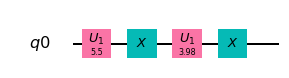

In [12]:
# circuit for unitary operator exp(iHt)
t = 1
unitary = QuantumCircuit(q)

unitary.u1(e2 * t, q[0]) # q[0] is the only qubit in q register
unitary.x(q[0])
unitary.u1(e1 * t, q[0])
unitary.x(q[0])
unitary.draw(output='mpl')

Where 

$$
u1(\lambda) = \begin{pmatrix}
1 & 0\\
0 & e^{i\lambda}
\end{pmatrix},
\qquad
X = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}
$$

are quantum gates. 

We may check that for an arbitrary one qubit quantum state $\left| \psi \right\rangle = c_1 \left| 0 \right\rangle + c_2 \left| 1 \right\rangle$ the gate sequence presented in the above code will produce the desired  $e^{iHt} \left| \psi \right\rangle$ evolution:

$$
e^{iHt} \left| \psi \right\rangle = c_1 e^{ie1t} \left| 0 \right\rangle + c_2 e^{ie2t} \left| 1 \right\rangle
$$

The next code creates a controlled version of the ```unitary``` that we will use in the algorithm. 

Why do we need it? When we apply controlled ```unitary``` ($CU$) on a two-qubit arbitrary quantum state:

$$
\left| \psi \right\rangle = c_1 \left| 00 \right\rangle + c_2 \left| 01 \right\rangle + c_3 \left| 10 \right\rangle + c_4 \left| 11 \right\rangle
$$

The ```unitary``` will be applied only if the first qubit is in $\left| 1 \right\rangle$, otherwise, it will not do anything. The quantum state after $CU$:

$$
\left| \psi \right\rangle = c_1 \left| 00 \right\rangle + c_2 \left| 01 \right\rangle + c_3 e^{ie1t} \left| 10 \right\rangle + c_4 e^{ie2t} \left| 11 \right\rangle.
$$

And if you apply $CU$ some $n$ times you will obtain:

$$
\left| \psi \right\rangle = c_1 \left| 00 \right\rangle + c_2 \left| 01 \right\rangle + c_3 e^{i n e1t} \left| 10 \right\rangle + c_4 e^{i n e2t} \left| 11 \right\rangle.
$$

We represent the phase in the fractional binary representation (it's up to us how to represent a number):

$$\varphi_2 = 0.\varphi_0 \varphi_1 \varphi_2 \varphi_3... =  \frac{\varphi_0}{2} + \frac{\varphi_1}{2^2} + \frac{\varphi_2}{2^3} + \frac{\varphi_3}{2^4} + ...$$

where each $\varphi_k$ is a bit (it is equal to $0$ or $1$). The algorithm at each iteration will estimate one $\varphi_k$ bit from the fractional binary representation of the phase.

At each iteration we are going to prepare our ancillary qubit in $\left| + \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle_a + \left| 1 \right\rangle_a \right)$ state. For that we apply Hadamard $H$ gate to the ancillary qubit:

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}.
$$

Then the qubit in the $q$ register is prepared in the $\left| 1 \right\rangle$ eigenstate of our diagonal Hamiltonian, which corresponding eigenvalue we want to estimate. For that, we apply $X$ gate to the qubit in the $q$ register. Here is the obtained quantum state after Hadamard and $X$ gates:

$$
\left|+ \right\rangle_a \left| 1 \right\rangle_q = \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle_a + \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q = \frac{1}{\sqrt{2}} \left( \left| 01 \right\rangle +  \left| 11 \right\rangle \right)
$$

If we apply controlled ```unitary``` circuit it will produce the following quantum state:

$$
\left| + \right\rangle_a \left| 1 \right\rangle_q \xrightarrow{\text{CU}}
\frac{1}{\sqrt{2}} \left( \left| 01 \right\rangle + e^{-i 2 \pi e2 t} \left| 11 \right\rangle \right) = 
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi \varphi_2} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q,
$$

because $\varphi_2 = e2 t$. If we apply controlled ```unitary``` circuit $2^{k}$ times the state of the qubits will look like this:

$$
\left| + \right\rangle_a \left| 1 \right\rangle_q \xrightarrow{\text{CU}}
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi \left( 2^{n} \varphi_2 \right)} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q = 
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi 0.\varphi_{k+1}...\varphi_{n}} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q,
$$

where $n$ is the index of the last bit (for $5$ qubits $n=4$ ). This will let us store different portions of the phase in the ancillary qubit.

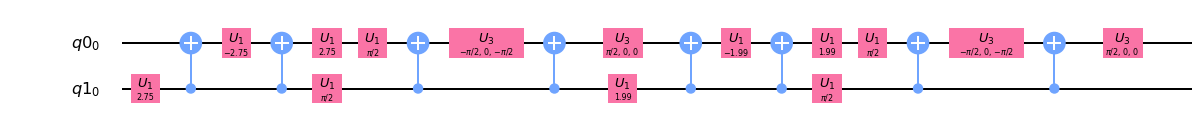

In [13]:
control_u = get_controlled_circuit(unitary, a[0])
control_u.draw('mpl')

In the first iteration, we estimate the last bit $\varphi_n$. For that, we are applying controlled ```unitary``` $2^{n}$ times. After this we will have the following quantum state:

$$
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi 0.\varphi_{n}} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q
$$

Estimating $\varphi_{n}$ from this state is straightforward. Depending on $\varphi_{n}$ there are two possible quantum states for the ancillary qubit:

$$
\left| + \right\rangle_a = \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle_a + \left| 1 \right\rangle_a \right)
\qquad \text{ or } \qquad
\left| - \right\rangle_a = \frac{1}{\sqrt{2}} \left( \left| 0 \right\rangle_a - \left| 1 \right\rangle_a \right)
$$

The next step is applying $H$ gate. Remember that $H \left| + \right\rangle_a = \left| 0 \right\rangle$ and $H \left| - \right\rangle_a = \left| 1 \right\rangle$ and after the measurement, we will have either $0$ or $1$ outcome. If the measurmet yields $0$, then $\varphi_n = 0$ and if it yields $1$, then $\varphi_n = 1$.

After this step, the same procedure is done for $n-1$ bit of the $\varphi$. This time we apply controlled ```unitary``` $2^{n-1}$ times. The quantum state:

$$
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi 0.\varphi_{n-1}\varphi_{n}} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q
$$

Before the Hadamard gate, we apply ```u1``` gate that subtracts from the phase already measured/known $\varphi_{n}$. After ```u1``` gate:

$$
\left( \left| 0 \right\rangle_a + e^{-i 2 \pi 0.\varphi_{n-1}} \left| 1 \right\rangle_a \right) \left| 1 \right\rangle_q
$$

With this wavefunction, it is easy to estimate the $\varphi_{n-1}$. For $k$th iteration the circuit looks like this:

<img src="images/iqpe_circuit.png" alt="drawing" width="400"/>

where $\varphi^{'} = (0.0\varphi_{k + 1}\varphi_{k + 2}\varphi_n)$.

The following ```for``` loop iteratively creates circuits for IQPE iterations. Every iteration estimates one bit of the $\varphi$.

In [7]:
num_bits_estimate = 10
phase = 0
for k_precision in reversed(range(num_bits_estimate)):
    # Create a Quantum Circuit acting on the q register
    k_circ = QuantumCircuit(q, a, c)

    # (1) |1> eigenstate initialization
    k_circ.x(q[0])

    # (2) Initial Hadamard gate applied on ancillary qubit.
    k_circ.h(a[0])

    # (3) The control Hamiltonian applied on the qubits where control qubit is the ancillary qubit.
    for order in range(2 ** k_precision):
        k_circ += control_u

    # (4) The phase gate and final Hadamard gate on ancillary qubit.
    phase_shift = 2 * np.pi * phase * 2 ** k_precision
    k_circ.u1(-phase_shift, a[0])
    k_circ.h(a[0])

    # (5) Measurement of ancillary qubit (findig the bit)
    k_circ.measure(a[0], c[0])

    # (6) executing on Quantum Computer and finding a bit from the phase
    job = execute(k_circ, backend, shots=1000)
    result = job.result()
    counts = result.get_counts()
    value = int(max(counts, key=counts.get))

    # (7) phase after this iteration
    phase += value / 2 ** (k_precision + 1)

Finally we are estimating the eigenvalue (energy) of the $\left| 1 \right\rangle$ eigenstate and printing the result alongside the true eigenvalue $e2$.

In [14]:
eigenvalue = 2 * np.pi * phase / t
print("Eigenvalue of the Hamiltonian: {}".format(e2))
print("Estimated eigenvalue of the Hamiltonian: {}".format(eigenvalue))

Eigenvalue of the Hamiltonian: 5.503527684131948
Estimated eigenvalue of the Hamiltonian: 5.724816300389213


We omitted one step of the algorithm. That is the Trotter decomposition step. For some Hamiltonian $H = h_1 + h_2 + h_3$ we need to exponentiate it to obtain $U = e^{i H t}$ unitary operator. Actually with this algorithm (namely when we are constructing a circuit with ```evolve``` method) we obtain $\tilde{U} = e^{i h_1 t} \cdot e^{i h_2 t} \cdot e^{i h_3 t}$. Actually, $e^{iHt} \ne  e^{i h_1 t} \cdot e^{i h_2 t} \cdot e^{i h_3 t}$. To obtain more or less valid $U$ operator we should do Trotter decomposition:

$$ U = (e^{i h_1 \frac{t}{N}} \cdot e^{i h_2 \frac{t}{N}} \cdot e^{i h_3 \frac{t}{N}})^N + O(\frac{t^2}{N}),$$

where $N$ is the Trotter number [[2](https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441)]. By increasing $N$ it is possible to obtain better representation for $U$ operator. Because our example of the Hamiltonian was simple (2x2 diagonal matrix) a reasonable result was obtained without doing this step.

One more thing. If $E_2 < 0$ then the final step of the algorithm is changed a little bit. In that case, note that $e^{iE_2t} = e^{-i \left|E_2 \right| t } = e^{i \left( 2 \pi-\left|E_2 \right| t \right) } = e^{i \varphi_2^* }$. Because of this, the algorithm will estimate $\varphi_2^* = 2 \pi-\left|E_2 \right| t$ and in the final step instead of $E_2 = 2  \pi  \varphi_2^* / t$ we should write $E_2 = -2  \pi  (1 - \varphi_2^*) / t$.

[1][J.D. Whitfield,  J. Biamonte  and  A. Aspuru-Guzik,
Molecular Physics, "Simulation of electronic structure Hamiltonians using
quantum computers" (2011)](https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441)